In [1]:
# Bring your packages onto the path
import sys, os
# include directory 3 levels up 
# for 1 level up '..' 
# for 2 levels '../..'
sys.path.append(os.path.abspath(os.path.join('../..')))

In [10]:
import numpy as np
factorial = np.math.factorial

import matplotlib.pyplot as plt
from tqdm import tqdm # module for progress bar (https://pypi.org/project/tqdm/)

# custom module where all models are written
from Models.Mechanical_Oscillator.mechanical_oscillator import mech_oscillator # model
from Models.Mechanical_Oscillator.mechanical_oscillator import mech_oscillator_samples # sample generator
from Models.Mechanical_Oscillator.mechanical_oscillator import mech_oscillator_isoprob_transform # isoprobabilistic transform

# custom module
import Surrogates.PolynomialChaosExpansion as PCE

# Gauß-Legendre Quadrature

Exactly integrates polynomial of degree: 2*number_of_quadrature_points-1

numpy package has been tested upto 100 points

In [3]:
def GaussLegendreQuadrature(lowerlimit, upperlimit, number_of_quadrature_points):

    # numpy method that provides Gauß-Legendre quadrature points and weights 
    quad_points, quad_weights = np.polynomial.legendre.leggauss(number_of_quadrature_points)

    # scaling for change of interval from [-1, 1] to [a, b]
    quad_points = ( (upperlimit-lowerlimit)/2 ) * quad_points + ( (upperlimit+lowerlimit)/2 )
    quad_weights = ( (upperlimit-lowerlimit)/2 ) * quad_weights

    return quad_points, quad_weights

# Generalised Sobol Indices using PCE Surrogate

In [12]:
class GSI_PCE(PCE.PCE_surrogate):

    def __init__(self, number_training_points, total_polynomial_degree, polynomial_classes_of_random_variables, 
                 model, sample_generator, isoprob_transform):

        self.training_points = number_training_points
        self.n = total_polynomial_degree
        self.pcrv = polynomial_classes_of_random_variables
        self.N_p = len(self.pcrv)
        self.model = model
        self.sample_generator = sample_generator
        self.isoprob_transform = isoprob_transform

        # set classes of random variables
        for i in range(self.N_p):

            if self.pcrv[i] == 'Hermite':
                self.pcrv[i] = PCE.Hermite

            if self.pcrv[i] == 'Legendre':
                self.pcrv[i] = PCE.Legendre

        #total number of polynomial terms in the PCE
        self.number_of_PCE_terms = int (factorial(self.N_p+self.n) / ( factorial(self.N_p) * factorial(self.n) ))

        self.all_permutations, self.comb_dict = PCE.compute_all_permutations(self.n, self.N_p)

    def generalised_Sobol(self, t_min, t_max, PCE_error):

        first_order_picker, total_order_picker = self.coefficient_pickers()

        # Numerical integration in time: T = [0, t_max]
        number_quad_points = 20
        self.T, quad_weights = GaussLegendreQuadrature(t_min, t_max, number_quad_points)

        # store generalised first order Sobol index
        self.G_U_store = np.zeros((self.N_p))

        # store generalised total order Sobol index
        self.G_U_t_store = np.zeros((self.N_p))

        # generalised first order Sobol index
        G_U_numerator = 0

        # generalised total order Sobol index
        # denominator is same in both cases
        G_U_t_numerator = 0
        G_U_t_denominator = 0

        # store error at each quad_point
        self.store_PCE_error = np.zeros(number_quad_points)

        # pick random samples for computing coefficients
        X_train = self.sample_generator(self.training_points)

        for i, t in enumerate(self.T):

            # evaluate model 
            Y = self.model(X_train, t)

            # find PCE coefficients
            y = self.find_coefficients(X_train, Y)

            if PCE_error:

                # error_estimate
                self.store_PCE_error[i] = self.LeaveOneOut(X_train, Y)

            G_U_numerator += first_order_picker @ (y**2) * quad_weights[i]

            G_U_t_numerator += total_order_picker @ (y**2) * quad_weights[i]

            G_U_t_denominator += np.sum(y[1:]**2) * quad_weights[i]

            G_U = G_U_numerator/G_U_t_denominator

            G_U_t = G_U_t_numerator/G_U_t_denominator

        self.G_U_store = G_U.flatten()
        self.G_U_t_store = G_U_t.flatten()

        return self.G_U_store, self.G_U_t_store


    def plot_Sobol_indices(self, PCE_error = False):

        # compute Sobol Indices and Leave One Out Error
        self.generalised_Sobol(PCE_error)

        # resolution of plot goverened by number of quadrature points in self.T
        fig, ax = plt.subplots(1, 2,figsize=(15,5)) 

        'Evolution of general total Sobol indices'
        ax[0].plot(self.T, self.G_U_t_store[0,:], color = 'red', label = 'alpha')
        ax[0].plot(self.T, self.G_U_t_store[1,:], color = 'blue', label = 'beta')
        ax[0].plot(self.T, self.G_U_t_store[2,:], color = 'black', label = 'l')

        ax[0].legend()
        ax[0].set_xlabel('time')
        ax[0].set_ylabel('General Total Sobol indices')

        'Evolution of general first order Sobol indices'
        ax[1].plot(self.T, self.G_U_store[0,:], color = 'red', label = 'alpha')
        ax[1].plot(self.T, self.G_U_store[1,:], color = 'blue', label = 'beta')
        ax[1].plot(self.T, self.G_U_store[2,:], color = 'black', label = 'l')

        ax[1].legend()
        ax[1].set_xlabel('time')
        ax[1].set_ylabel('General First Order Sobol indices')

        plt.show()

        if PCE_error == True:
            self.plot_PCE_error()

    def plot_PCE_error(self):

        # resolution of plot goverened by number of quadrature points in self.T
        fig, ax = plt.subplots(figsize=(6,5)) 

        ax.plot(self.T, self.store_PCE_error, color = 'red')
        ax.set_xlabel('time')
        ax.set_ylabel('PCE Error')
        ax.set_title('Leave One Out PCE Error')

        plt.show()


In [13]:
number_training_points = 10_000
n = 5
polynomial_classes_of_random_variables = ['Legendre', 'Legendre', 'Legendre']
model = mech_oscillator
sample_generator = mech_oscillator_samples

mech_oscillator_PCE = GSI_PCE(number_training_points, n, polynomial_classes_of_random_variables, 
                                    model, sample_generator, mech_oscillator_isoprob_transform)

# Generalised Sobol Indices with PCE Surrogate

In [14]:
mech_oscillator_PCE.generalised_Sobol(0.1, 10, False)

(array([0.01937988, 0.86241245, 0.06916211]),
 array([0.05047598, 0.91105266, 0.08811789]))

In [17]:
n_t = 51
N_p = 3
t_linspace = np.linspace(0.1, 10, n_t)

G_U_evolution = np.zeros((N_p, n_t))
G_total_U_evolution = np.zeros((N_p, n_t))

for j, t in enumerate(tqdm(t_linspace, desc = 'Computing Indices', ncols=100)):

    G_U, G_total_U = mech_oscillator_PCE.generalised_Sobol(0.1, t, False)

    G_U_evolution[:, j] =  G_U
    G_total_U_evolution[:, j] = G_total_U

Computing Indices:   0%|                                                    | 0/101 [00:00<?, ?it/s]/home/i1000609/.local/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in true_divide
/home/i1000609/.local/lib/python3.6/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in true_divide
Computing Indices: 100%|██████████████████████████████████████████| 101/101 [00:39<00:00,  2.54it/s]


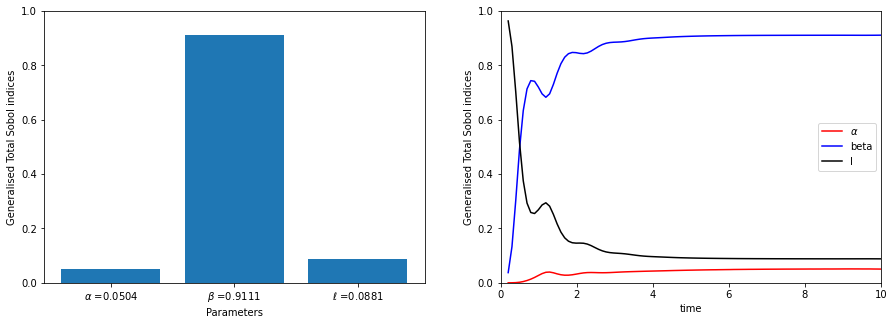

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

'Histogram of general total Sobol indices at t=T'
params = [r'$\alpha$ =' + str(np.around(G_total_U_evolution[0,-1], 4)), 
          r'$\beta$ =' +  str(np.around(G_total_U_evolution[1,-1], 4)), 
          r'$\ell$ =' +     str(np.around(G_total_U_evolution[2,-1], 4))]

ax[0].bar(params,G_total_U_evolution[:,-1])
ax[0].set_ylim(0, 1)
ax[0].set_xlabel('Parameters')
ax[0].set_ylabel('Generalised Total Sobol indices')

'Evolution of general total Sobol indices'
ax[1].plot(t_linspace,G_total_U_evolution[0,:], color = 'red',   label = r'$\alpha$')
ax[1].plot(t_linspace,G_total_U_evolution[1,:], color = 'blue',  label = 'beta')
ax[1].plot(t_linspace,G_total_U_evolution[2,:], color = 'black', label = 'l')
plt.xlim(0, 10)
plt.ylim(0, 1)
ax[1].legend()
ax[1].set_xlabel('time')
ax[1].set_ylabel('Generalised Total Sobol indices')
plt.show()